In [1]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sktime.transformations.panel.rocket import Rocket
from tqdm import tqdm
from scipy.io import loadmat
from scipy.stats import zscore
import matplotlib.pyplot as plt

In [2]:
SENSOR = 1
activitymap = {1: "Walking Forward", 2: "Walking Left", 3: "Walking Right", 4: "Walking Upstairs", 5: "Walking Downstairs", 6: "Running Forward", 7: "Jumping Up", 8: "Sitting", 9: "Standing", 10: "Sleeping", 11: "Elevator Up", 12: "Elevator Down"}
omitactivities=["a8t","a9t","a10"]
main_dir = 'USC-HAD/'
i = 0
dataset = []
labels = []
lens = []
for (root,dirs,files) in os.walk(main_dir):
    for d in dirs:
        for (subj_root,subj_dirs,subj_files) in os.walk(root+d):
            for f in subj_files:
                if f[:3] not in omitactivities:
                    filedata = loadmat(main_dir+d+"/"+f)
                    filedata = np.asarray(filedata['sensor_readings'])
                    filedata = filedata[:,SENSOR] 
                    filedata = np.transpose(filedata) 
                    label = f[1:-6] 
                    lens.append(len(filedata))
                    dataset.append(zscore(filedata, nan_policy='omit', axis=0))
                    labels.append(label)
print("FINISHED PROCESSING DATA")

FINISHED PROCESSING DATA


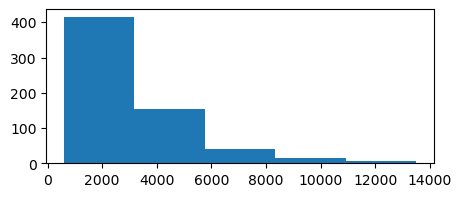

In [3]:
values, counts = np.unique(lens,return_counts=True)   
fig = plt.figure(figsize=(5,2))
plt.hist(lens, bins=5)
plt.show()

longest_len = max(lens)
padtype = "self" # also "self"
for ts_idx in range(len(dataset)):
    ts = dataset[ts_idx]
    if padtype == "zero":
        dataset[ts_idx] = np.pad(ts,(0,longest_len-len(ts)),mode='constant')
    elif padtype == "self":
        dataset[ts_idx] = np.pad(ts,(0,longest_len-len(ts)),mode='wrap')


In [4]:
rocket_labels_MAIN = np.asarray(labels)
rocket_dataset_MAIN = np.stack(dataset,axis=0)
rocket_dataset_MAIN = np.expand_dims(rocket_dataset_MAIN,axis=2)

scores = []
for i in tqdm(range(len(rocket_labels_MAIN))): # LOO
    X_train, X_test = np.delete(rocket_dataset_MAIN,i,axis=0), rocket_dataset_MAIN[i]
    X_test = np.expand_dims(X_test,axis=0)
    y_train, y_test = np.delete(rocket_labels_MAIN,i), rocket_labels_MAIN[i]

    X_test = np.concatenate((X_test, X_test)) # due to sktime implementation, it requires X_test to have more than one datapoint
    y_test = np.expand_dims(y_test,axis=0)
    y_test = np.concatenate((y_test,y_test))
    y_test = np.expand_dims(y_test,axis=1) # again
    
    rocket = Rocket()  # by default, ROCKET uses 10,000 kernels
    rocket.fit(X_train)
    X_train_transform = rocket.transform(X_train)
    classifier = RidgeClassifierCV(alphas=np.logspace(-3,3,10), normalize=False) # normalized already
    classifier.fit(X_train_transform, y_train)

    X_test_transform = rocket.transform(X_test)
    scores.append(classifier.score(X_test_transform, y_test))
print(np.mean(scores))

100%|██████████| 630/630 [1:54:46<00:00, 10.93s/it]  

0.0
